##   <font color='Aquamarine'>Import libraries</font> 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import zipfile


# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/braintumordataset/dataset.zip", 'r')
# zip_ref.extractall("/content/drive/MyDrive/braintumordataset/")
# zip_ref.close()

In [3]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# from keras_efficientnets import EfficientNetB3
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5,InceptionResNetV2#,EfficientNetV2S
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import keras
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
#from pretty_confusion_matrix import pp_matrix
#confusion_matrix = metrics.confusion_matrix(y_true=y_test_labels, y_pred=pred_labels)  # shape=(12, 12)
from sklearn.metrics import confusion_matrix

## <font color='Aquamarine'>Create labels</font> 

In [4]:
#create labels
classes=[]
filename='/content/drive/MyDrive/braintumordataset/dataset'
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


## <font color='Aquamarine'>Resize images and put together Training and Testing folder</font> 

In [5]:
#resize images and put together Training and Testing folder

X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)): #Instantly make your loops show a smart progress meter 
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)    

100%|██████████| 74/74 [00:00<00:00, 108.48it/s]


## <font color='Aquamarine'>Data augmentation and splitting</font> 

In [6]:
#data augmentation
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7, #rotate images
    width_shift_range=0.05,
    height_shift_range=0.05, #shift image in horizontal and vertical
    zoom_range=0.1, #zoom images
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape
lb = LabelEncoder()

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

## <font color='Aquamarine'>Load EfficientNetB3</font> 

In [7]:
print(y_train)

#load EfficientNet
EfficientNet=EfficientNetB3(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

[3 1 1 ... 3 3 0]
43950080/43941136 [==============================] - 0s 0us/step


## <font color='Aquamarine'>Train the model</font> 

In [8]:
#train the model
tf.random.set_seed(45)
model = EfficientNet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.55)(model)
model = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model)
model = tf.keras.layers.Dropout(rate=0.3)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=EfficientNet.input, outputs = model)
opt = Adam(
    learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,
    epsilon=1e-08)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# summarize the model
print(model.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=9,restore_best_weights=True)

#uncomment to train



# history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=90,
#     batch_size=13,callbacks=early_stopping_cb)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 160, 160, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 161, 161, 3)  0           ['normalization[0][0]']      

In [9]:
y_train.shape,y_test.shape

((2774,), (490,))

## <font color='Aquamarine'>Save the model</font> 

In [12]:
#uncomment to save pretrained model
# model.save('/content/drive/MyDrive/braintumordataset/effmodel.h5')


In [13]:
 #load the model
model=keras.models.load_model('/content/drive/MyDrive/braintumordataset/effmodel.h5')  

model.summary()
loss, accuracy = model.evaluate(X_test,y_test)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 160, 160, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 161, 161, 3)  0           ['normalization[0][0]']      

In [ ]:
image="/content/drive/MyDrive/dataset/brain/dataset/Testing/meningioma_tumor/image(1).jpg"

In [ ]:
img = cv2.imread(image)
img = cv2.resize(img,(image_size,image_size))

In [ ]:
img = np.asarray(img)
img = np.expand_dims(img, axis=0)
output = model.predict(img)
print(np.argmax(output))

1


In [ ]:

#  More details about the model
'''
for i, layer in enumerate (model.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')
#specific info about each layer
for i in range(len(model.layers)):
    print(f'{i}   {model.layers[i]}: \n{model.layers[i].get_config()} \n')
'''

#info about optimizers
model.optimizer.get_config()  

## <font color='Aquamarine'>Accuracy and Loss</font> 

In [14]:
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 96.939 
 loss : 0.081


In [15]:

y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred) #predicted labels

In [16]:
pd.Series(pred_labels).value_counts()

meningioma_tumor    141
pituitary_tumor     138
glioma_tumor        136
no_tumor             75
dtype: int64

## <font color='Aquamarine'>Confusion Matrix</font> 

Text(70.8, 0.5, 'Predicted class')

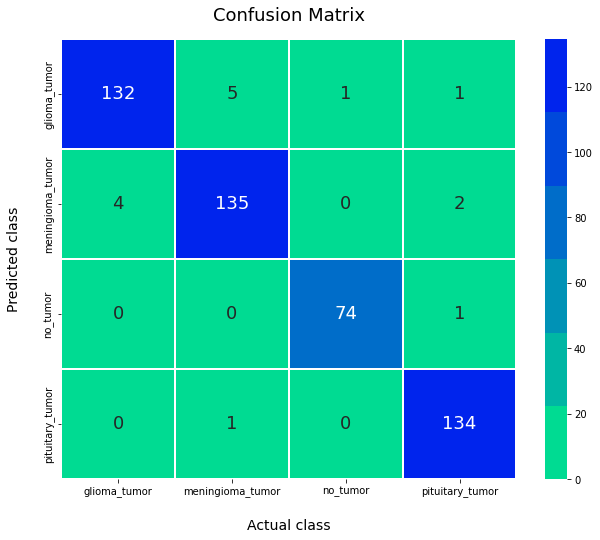

In [17]:
cm = confusion_matrix(y_test,pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r inverts the palette
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
 #annot_kws: settings about annotations
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)
#plt.savefig(os.path.join('plots/','EfficientNetB3_confusion_matrix.png'), dpi=300)

## <font color='Aquamarine'>Model performance scores</font> 

In [18]:
print(classification_report(y_test,pred,target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.95      0.96       139
meningioma_tumor       0.96      0.96      0.96       141
        no_tumor       0.99      0.99      0.99        75
 pituitary_tumor       0.97      0.99      0.98       135

        accuracy                           0.97       490
       macro avg       0.97      0.97      0.97       490
    weighted avg       0.97      0.97      0.97       490



In [ ]:
os.getcwd()

In [19]:
import matplotlib.image as mpimg
os.chdir('/content/drive/MyDrive/braintumordataset/dataset')
TEST_DIR='Testing'
#fetch images from the original validation dataset and resize them in order to plot the images.
images=[] 
n_classes=4
z_max=20
for i,filenames in enumerate(os.listdir(TEST_DIR)): 
    dir_fold=os.path.join(TEST_DIR, filenames)
    print(dir_fold)
    class_images=[]
    z=0
    for filename in os.listdir(dir_fold):
        if z < z_max:
            img_path = os.path.join(dir_fold, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img,(image_size,image_size))
            class_images.append(img)
            z+=1
        else:
            break
    images.append(class_images)
images=images[:20]


Testing/glioma_tumor
Testing/meningioma_tumor
Testing/no_tumor
Testing/pituitary_tumor


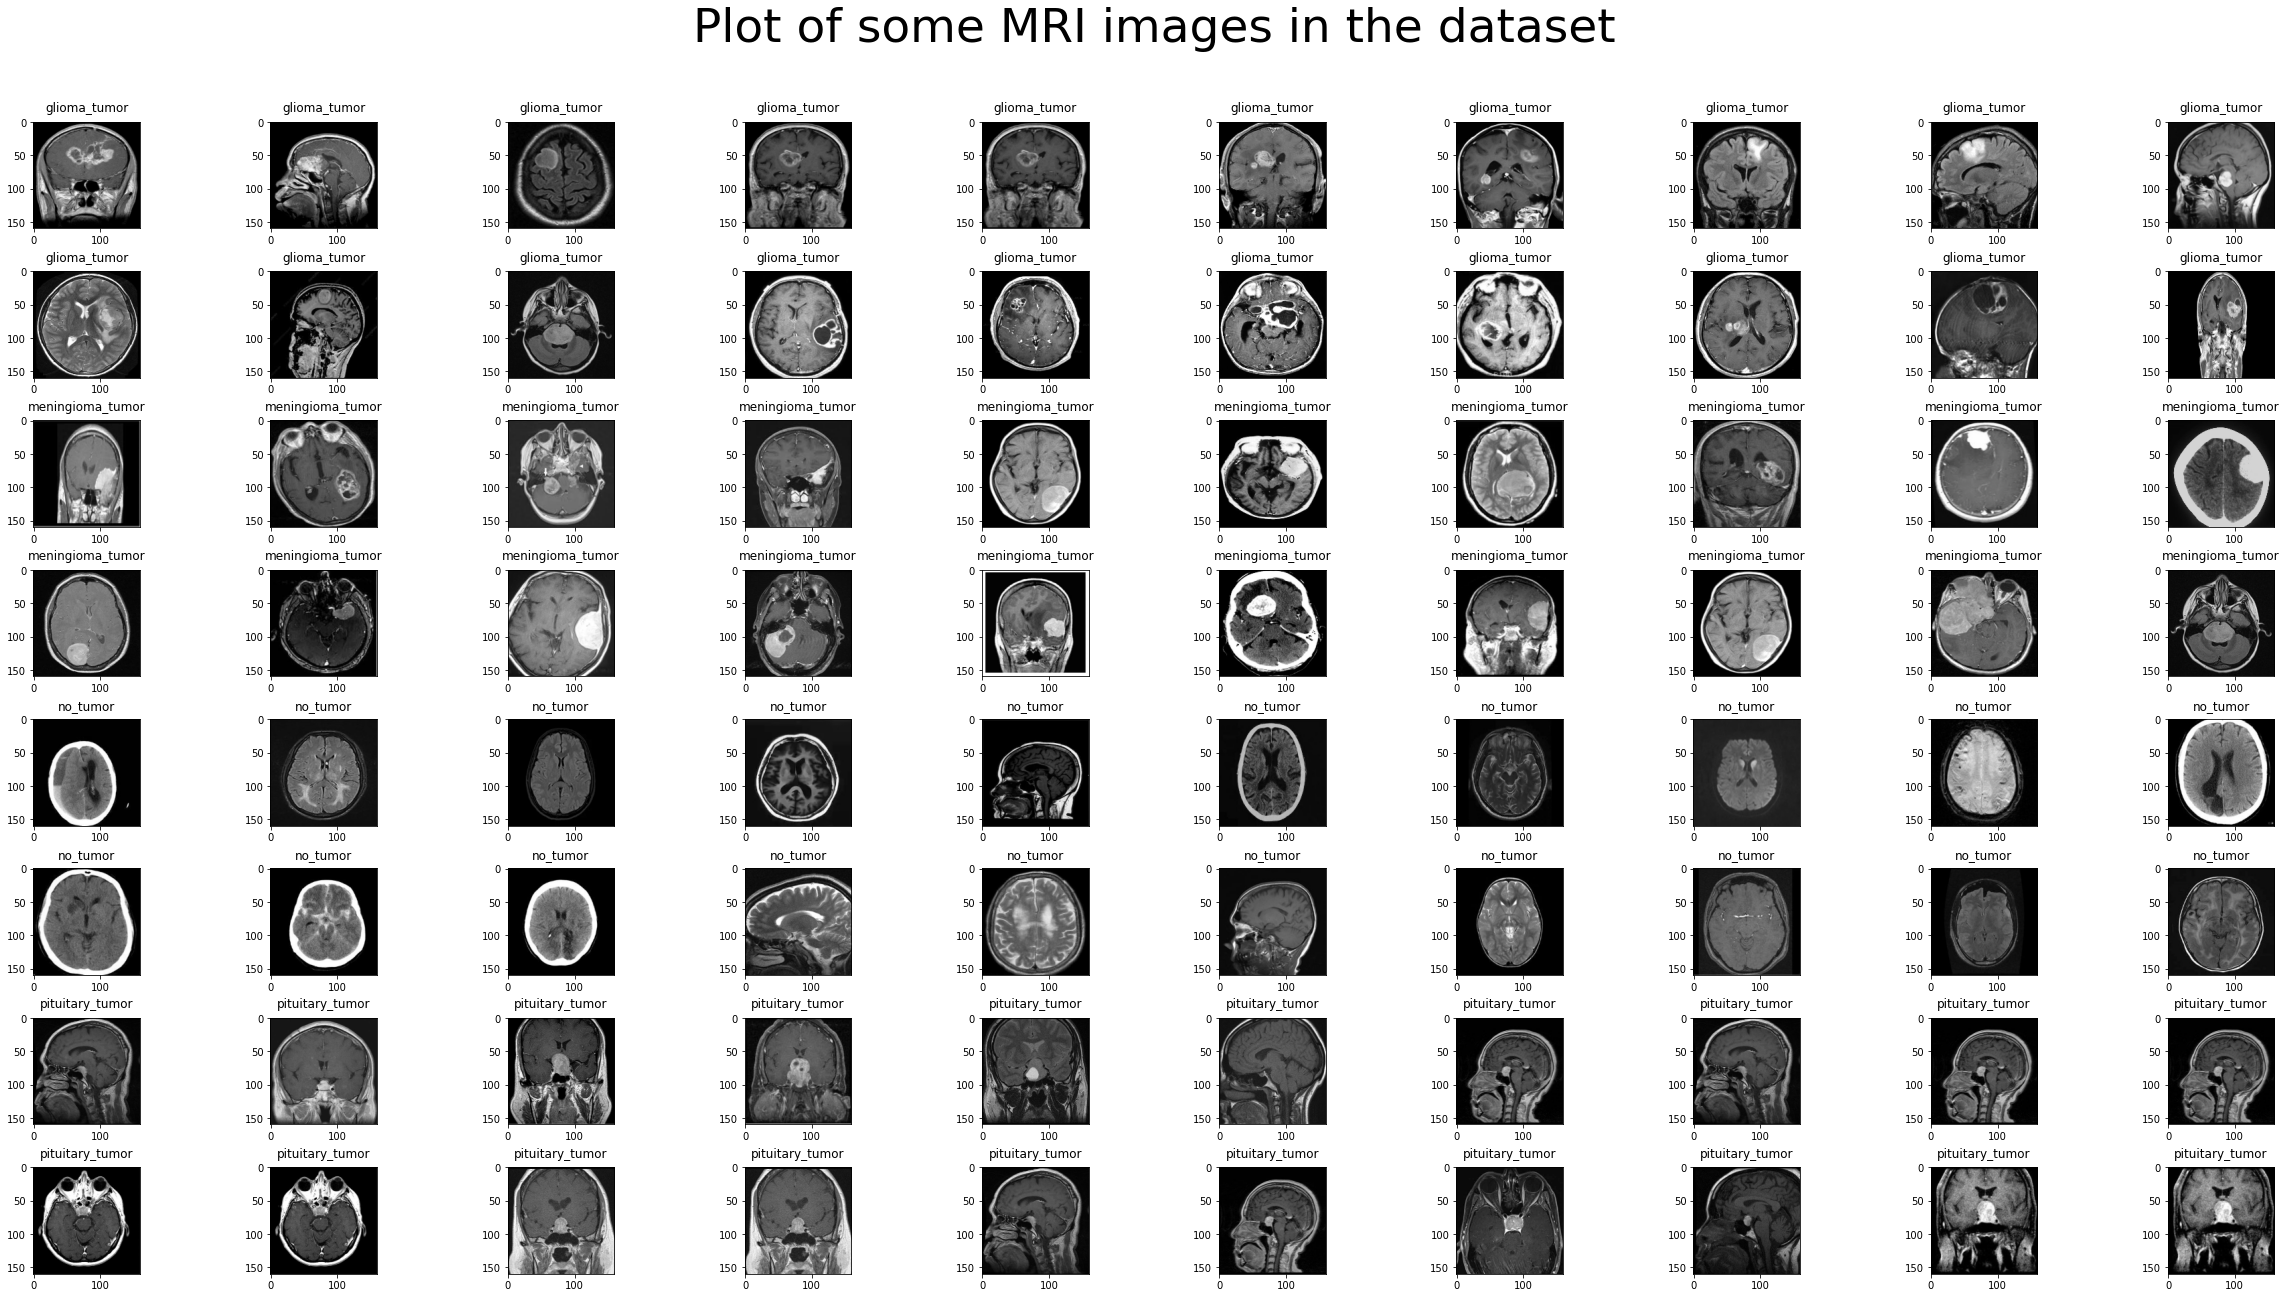

In [20]:
#here I plotted the images based on columns and z_max (defined by the user, 
#but it should be a multiple of the # of columns)
columns = 10
fig,axes=plt.subplots(int(len(images)*len(images[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(images):
    #print(images_class)
    fig.suptitle('Plot of some MRI images in the dataset',fontsize=47)
    for j, image in enumerate(ind):
        #print(j,image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)
#image_plotting(X_test[:1])
#plt.savefig(os.path.join('plots/','Some_MRI_images_in_the_dataset_white.png'), dpi=300,facecolor='w')

In [21]:
X_test_images=dict(zip(classes,[[],[],[],[]]))
for y,ele in enumerate(pred):
    for i,x in enumerate(X_test_images):
        #num=pred[ind]
        if ele==i:
            if len(X_test_images[classes[i]])<z_max:
                X_test_images[classes[i]].append(X_test[y])
X_test_images=[X_test_images[i]  for i in X_test_images]


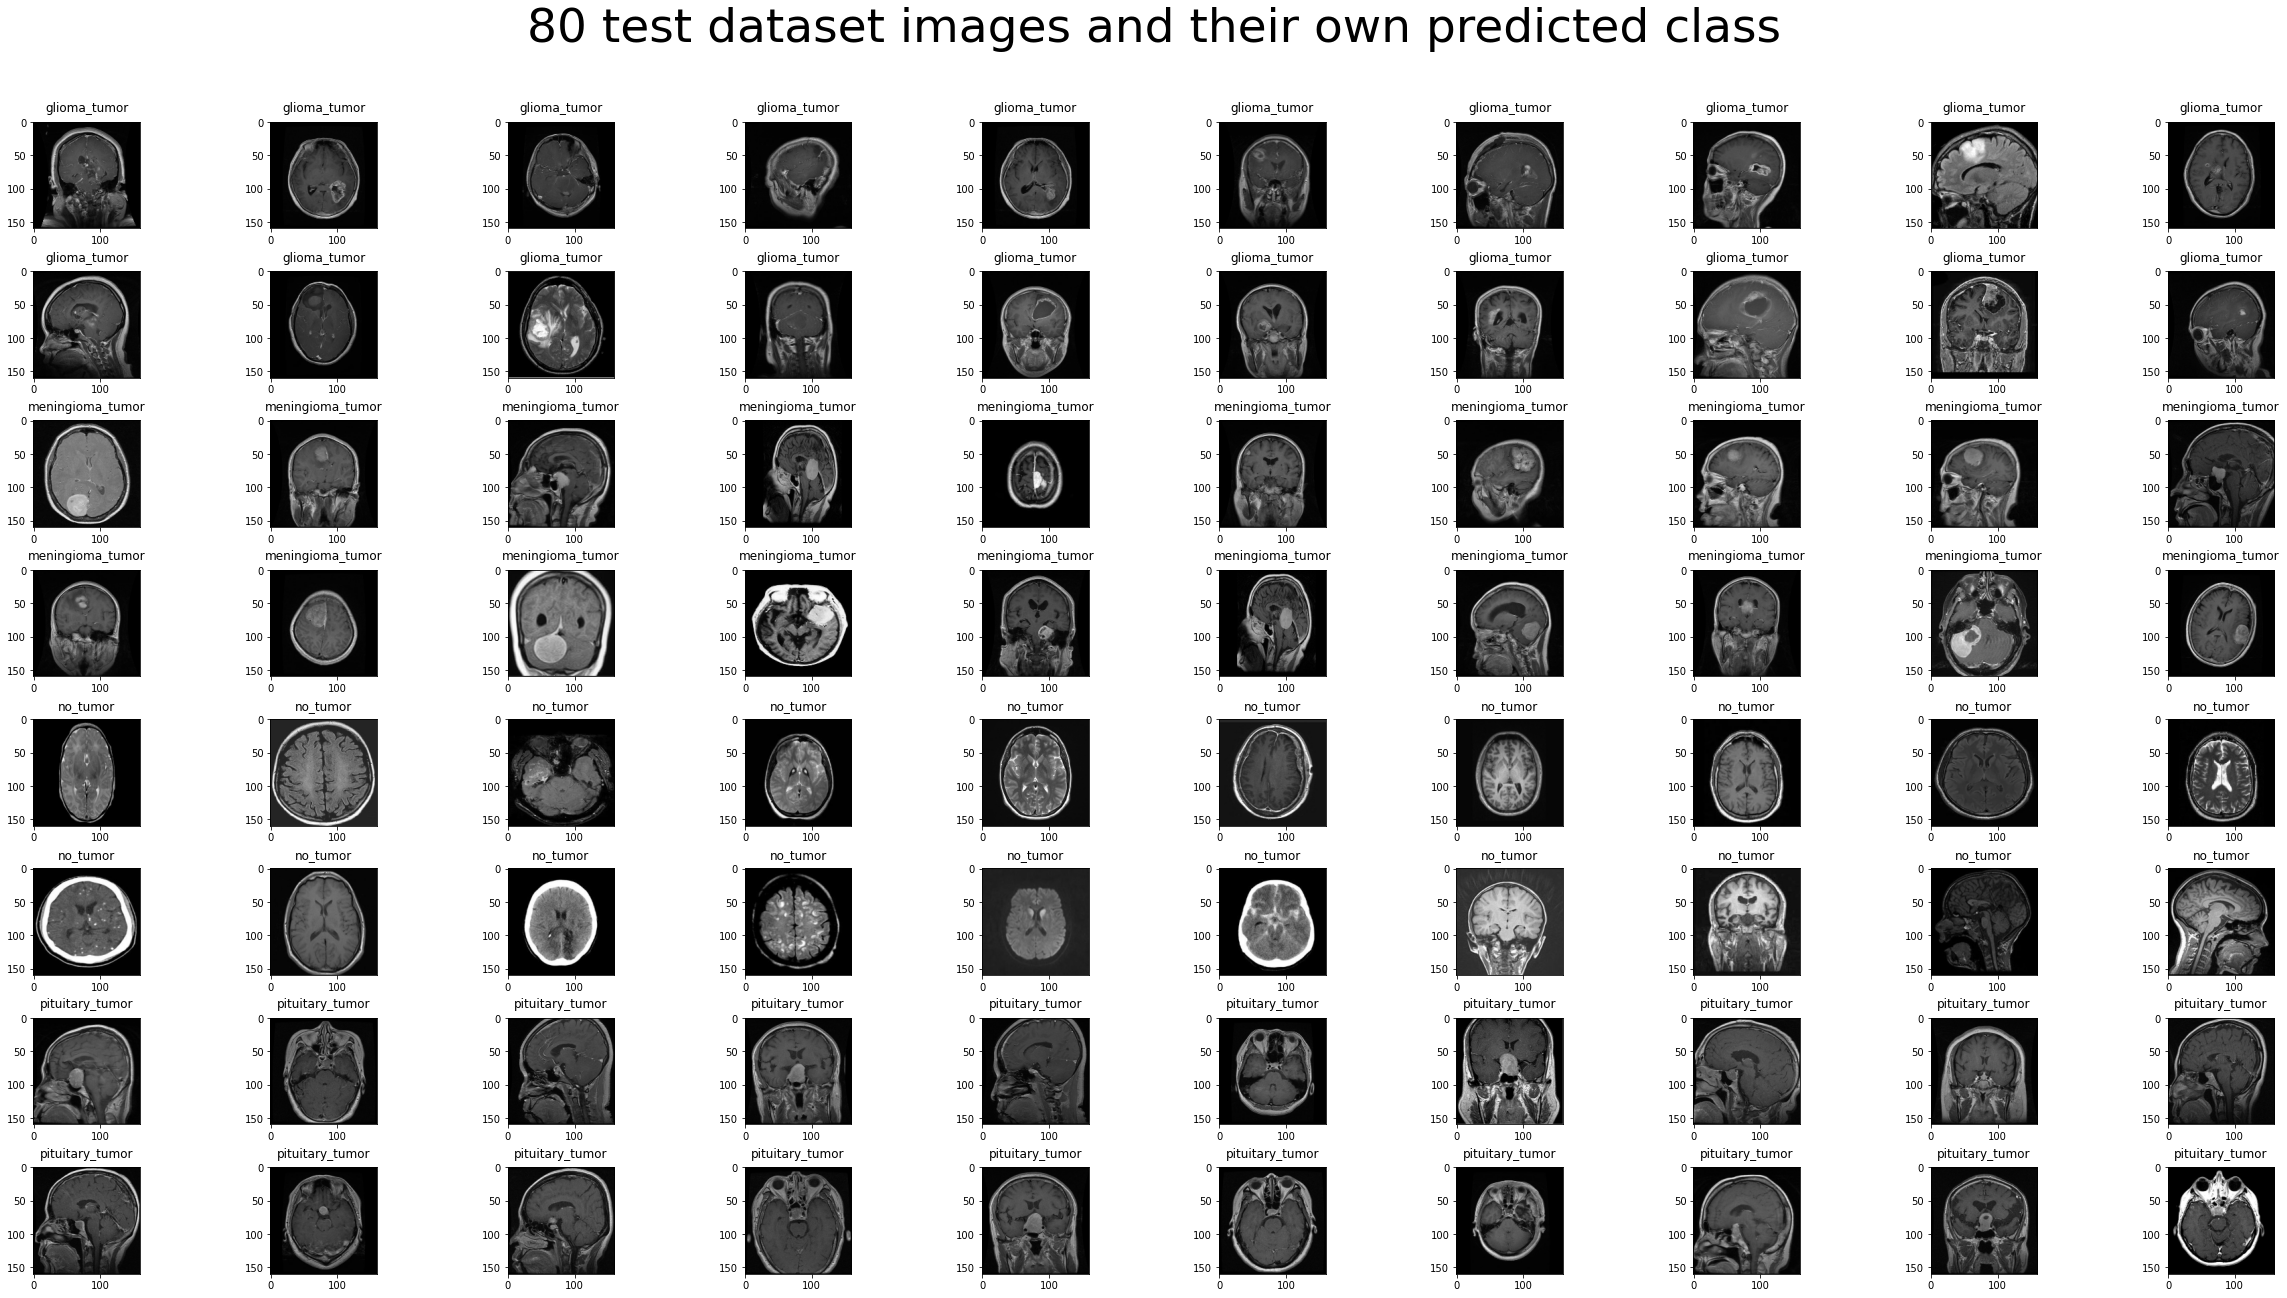

In [22]:
columns = 10
fig,axes=plt.subplots(int(len(X_test_images)*len(X_test_images[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(X_test_images):
    #print(images_class)
    fig.suptitle('80 test dataset images and their own predicted class',fontsize=47)
    for j, image in enumerate(ind):
        #print(j,image)
        if int((i)*(len(ind)/columns)+(int(j/columns)))<n_classes*(z_max/columns):
            axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
            axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)
#plt.savefig(os.path.join('plots/','80ValidationDatasetimages_and_predictedclass.png'), dpi=300)
#plt.savefig(os.path.join('plots/','80ValidationDatasetimages_and_predictedclass_white.png'), dpi=300,facecolor='w')

In [ ]:
X_test.shape